# Supply Chain 360: Predictive Analytics & Demand Forecasting
---

## 1. Project Context & Objectives
In the e-commerce industry, operational inefficiency often stems from inaccurate demand forecasting and logistical bottlenecks. This phase of the project focuses on the Data Science layer, transforming historical records into predictive insights to improve strategic decision-making.

### Key Goals:
* **Cloud Integration:** Authenticate and retrieve weekly aggregated data from Google BigQuery.
* **Time-Series Refinement:** Resample data to a weekly frequency and handle gaps with zero-filling to ensure mathematical continuity.

In [1]:
# 1. Librerías necesarias
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

auth.authenticate_user()
print("Verificacion completada con exito")

project_id = 'proyecto-brazilian-e-commerce'
client = bigquery.Client(project=project_id)

Verificacion completada con exito


## 2. Data Ingestion & Preprocessing
In this section, we establish a secure connection with Google BigQuery to retrieve the weekly aggregated data created during the SQL engineering phase.

* **Source:** `Supply_Chain_Analytics.data_forecast_semanal`.
* **Integrity:** We ensure the time series has a consistent weekly frequency and handle missing periods to maintain mathematical continuity for the forecasting model.

In [2]:
#  Query para traer los datos
query = """
SELECT *
FROM `Supply_Chain_Analytics.data_forecast_semanal`
ORDER BY semana ASC
"""

#  Convertir a DataFrame
df = client.query(query).to_dataframe()

#  Ajustes de formato
df['semana'] = pd.to_datetime(df['semana'])
df.set_index('semana', inplace=True)

# Usamos RESAMPLE.
df = df.resample('W-MON')['total_pedidos'].sum().to_frame()

# Rellenar semanas vacías con 0 por si hubo semanas sin ventas.
df['total_pedidos'] = df['total_pedidos'].fillna(0)

# Verificamos
print(df.head())
print(f"Total de pedidos cargados: {df['total_pedidos'].sum()}")

            total_pedidos
semana                   
2016-09-12              1
2016-09-19              0
2016-09-26              0
2016-10-03            211
2016-10-10             54
Total de pedidos cargados: 96478


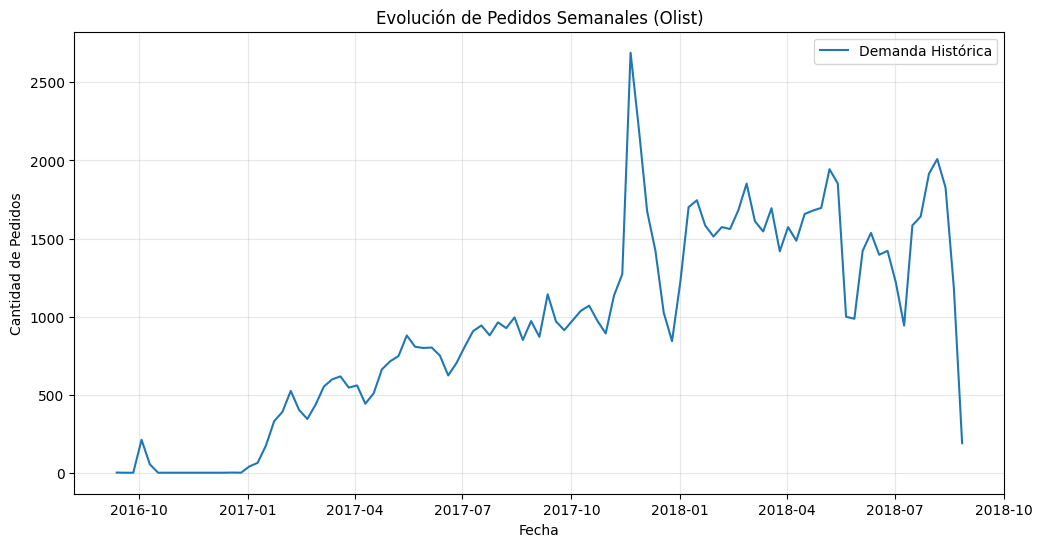

In [3]:
# Graficar la historia
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_pedidos'], label='Demanda Histórica', color='#1f77b4')
plt.title('Evolución de Pedidos Semanales (Olist)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pedidos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Methodology: Holt-Winters Model
We utilize the Holt-Winters (Triple Exponential Smoothing) method because it effectively decomposes the time series into level, trend, and seasonality.

### Model Parameters:
* **Trend ('add'):** Captures long-term upward or downward movement.
* **Seasonality ('add'):** Accounts for recurring patterns. We have set `seasonal_periods=4` to detect monthly consumption cycles, optimizing the model for the available data span.
* **Forecast:** Generation of an 8-week prediction to support proactive inventory planning.

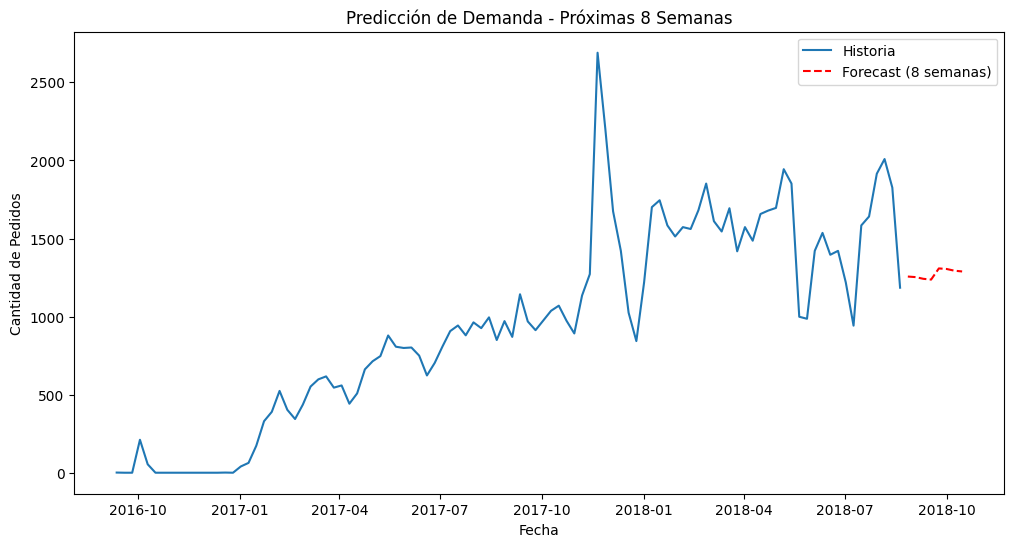

Tabla forecast guardada en BigQuery: proyecto-brazilian-e-commerce.Supply_Chain_Analytics.forecast_resultados


In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# LIMPIEZA FINAL
df_clean = df.iloc[:-1]

# ENTRENAMIENTO DEL MODELO (AJUSTADO)
# Buscamos patrones mensuales
modelo = ExponentialSmoothing(
    df_clean['total_pedidos'],
    trend='add',
    seasonal='add',
    seasonal_periods=4
).fit()

# PREDICCIÓN PARA LAS PROXIMAS 8 SEMANAS
semanas_a_predecir = 8
forecast = modelo.forecast(semanas_a_predecir)

# CREAR DATAFRAME DE RESULTADOS
df_forecast = pd.DataFrame(forecast, columns=['total_pedidos'])
df_forecast.index.name = 'semana'
df_forecast['tipo'] = 'Prediccion'

# Preparamos los datos históricos
df_historico = df_clean.copy()
df_historico['tipo'] = 'Historico'

# Unimos todo
df_final = pd.concat([df_historico, df_forecast]).reset_index()

# VISUALIZACIÓN
plt.figure(figsize=(12, 6))
plt.plot(df_historico.index, df_historico['total_pedidos'], label='Historia')
plt.plot(df_forecast.index, df_forecast['total_pedidos'], label='Forecast (8 semanas)', color='red', linestyle='--')
plt.title('Predicción de Demanda - Próximas 8 Semanas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pedidos')
plt.legend()
plt.show()

# GUARDAR EN BIGQUERY
table_id = f"{project_id}.Supply_Chain_Analytics.forecast_resultados"
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
job = client.load_table_from_dataframe(df_final, table_id, job_config=job_config)
job.result()

print(f"Tabla forecast guardada en BigQuery: {table_id}")

## 4. Strategic Impact (Organizational Perspective)
Beyond the technical implementation, this forecasting tool serves a human purpose. By identifying future demand peaks, we enable logistics teams to transition from reactive to proactive management.

This proactive approach reduces operational stress, prevents inventory stockouts, and ultimately fosters a healthier organizational climate and improved customer experience.